# Syncnet DEMO

https://github.com/voletiv/syncnet-in-keras/

1. Given a video (*.mp4), convert to proper input format to the Syncnet lip & audio models
2. Load the Syncnet lip and audio models
3. Calculate lip-video and audio embeddings using Syncnet
4. Calculate Euclidian distance between the lip and audio embeddings to check if video/audio are in sync

In [2]:
import cv2
import dlib
import numpy as np
import os
import scipy.io.wavfile as wav
import speechpy

import syncnet_params

from syncnet_functions import detect_mouth_in_frame, load_pretrained_syncnet_model
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# FUNCTIONS

## get_syncnet_lip_model_input

In [3]:
def get_syncnet_lip_model_input(video, shape_predictor_path="shape_predictor_68_face_landmarks.dat"):

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(shape_predictor_path)

    cap         = cv2.VideoCapture(video)
    frameFPS    = int(cap.get(cv2.CAP_PROP_FPS))
    frameCount  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print("FPS: {}".format(frameFPS))
    print("Frames: {}".format(frameCount))
    print("Width: {}".format(frameWidth))
    print("Height: {}".format(frameHeight))

    # Default face rect
    face = dlib.rectangle(30, 30, 220, 220)

    lip_model_input = []

    frame_index = 0

    # Read frames from the video
    while(cap.isOpened()):

        frames = []
        copy_over_frame = []
        
        
        for i in range(5):
        
            _, frame = cap.read()

            # If no frame is read, break
            if frame is None:
                break
            mouth, _ = detect_mouth_in_frame(frame, detector, predictor,
                                             prevFace=face, verbose=False)
            mouth = cv2.cvtColor(mouth, cv2.COLOR_BGR2GRAY)
            
            try:
                mouth = cv2.resize(mouth, (syncnet_params.MOUTH_W, syncnet_params.MOUTH_H))
                mouth = mouth - 110.
            except:
                return

            # Subtract 110 from all mouth values (Checked in syncnet_demo.m)
           
            frames.append(mouth)
            frame_index += 1
        
        if len(frames) == 5:
            stacked = np.stack(frames, axis=-1) #syncnet requires (112,112,5)
            lip_model_input.append(stacked)
        else:
            break
    
    
    
    return np.array(lip_model_input)

## get_syncnet_audio_model_input

In [4]:
def extract_syncnet_mfcc(wav_file, verbose=False):
    """To extract mfcc features of audio clips 0.2 seconds in length each,
    i.e. of 20 MFCC features in each clip (acc. to syncnet paper)
    Output mfcc_clips shape === (N, 12, 20, 1),
    where N = len(mfcc_features) // 20
    """

    rate, sig = wav.read(wav_file)
    if verbose:
        print("Sig length: {}, sample_rate: {}".format(len(sig), rate))

    try:
        mfcc_features = speechpy.feature.mfcc(sig, sampling_frequency=rate, frame_length=0.010, frame_stride=0.010)
    except IndexError:
        raise ValueError("ERROR: Index error occurred while extracting mfcc")

    if verbose:
        print("mfcc_features shape:", mfcc_features.shape)

    # Number of audio clips = len(mfcc_features) // length of each audio clip
    number_of_audio_clips = len(mfcc_features) // syncnet_params.AUDIO_TIME_STEPS

    if verbose:
        print("Number of audio clips:", number_of_audio_clips)

    # Don't consider the first MFCC feature, only consider the next 12 (Checked in syncnet_demo.m)
    # Also, only consider syncnet_params.AUDIO_TIME_STEPS*number_of_audio_clips features
    mfcc_features = mfcc_features[:syncnet_params.AUDIO_TIME_STEPS*number_of_audio_clips, 1:]

    # Reshape mfcc_features from (x, 12) to (x//20, 12, 20, 1)
    mfcc_features = np.expand_dims(np.transpose(np.split(mfcc_features, number_of_audio_clips), (0, 2, 1)), axis=-1)

    if verbose:
        print("Final mfcc_features shape:", mfcc_features.shape)

    return mfcc_features


def get_syncnet_audio_model_input(video):

    # Convert video's audio to .wav file
    audio_out = "{}.wav".format(video)
    command = "ffmpeg -y -loglevel panic -i {} -acodec pcm_s16le -ac 1 -ar 16000 {}".format(video, audio_out)
    os.system(command)

    # Extract proper input to syncnet_audio_model
    return extract_syncnet_mfcc(audio_out)

# 1. Given a video, convert to proper inputs to the Syncnet lip & audio models

### - Make sure video is of 25fps!
If not, use the following ffmpeg command to convert fps:

```
ffmpeg -i <video>.mp4 -r 25 -y <video_at_25_fps>.mp4
```

In [5]:
def convert_video_to_25_fps(video):
    cmd = "ffmpeg -i {} -r 25 -y tmp.mp4".format(video)
    os.system(cmd)
    cmd = "mv tmp.mp4 {}".format(video)
    os.system(cmd)
    return

In [6]:
video_to_test = "test/unsynced.mp4"

In [7]:
convert_video_to_25_fps(video_to_test)

### - Use dlib's landmarks predictor to extract mouth from frames

shape_predictor_68_face_landmarks.dat can be downloaded from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [8]:
shape_predictor_path = "shape_predictor_68_face_landmarks.dat"

### Convert video to Syncnet lip model input

In [9]:
lip_input = get_syncnet_lip_model_input(video_to_test, shape_predictor_path)

if(lip_input is None):
    print("Cannot detect mouth")

print(lip_input.shape)

FPS: 25
Frames: 184
Width: 320
Height: 240
(36, 112, 112, 5)


### Convert video's audio to Syncnet audio model input

In [10]:
audio_input = get_syncnet_audio_model_input(video_to_test)
print(audio_input.shape)

(36, 12, 20, 1)


# 2. Load the Syncnet lip and audio models

In [11]:
version = 'v4'
mode = 'both'
syncnet_audio_model, syncnet_lip_model = load_pretrained_syncnet_model(version=version, mode=mode, verbose=False)

In [12]:
# print(syncnet_audio_model.summary())

In [13]:
# print(syncnet_lip_model.summary())

# 3. Calculate lip-video and audio embeddings using Syncnet

In [14]:
audio_embeddings = syncnet_audio_model.predict(audio_input)
print(audio_embeddings.shape)

(36, 128)


In [15]:
lip_embeddings = syncnet_lip_model.predict(lip_input)
print(lip_embeddings.shape)

(36, 128)


# 4. Calculate Euclidian distance between the lip and audio embeddings to check if video/audio are in sync

1. Pass the audio frame through the audio model to get its encoding (a 128-dimensional feature), pass the video frame through the lip model to get its encoding (a 128-dimensional features)

2. Check the euclidean distance between the audio encoding and the video encoding.

3. If the distance is greater than a threshold, then it is said that audio frame and that video frame are not in sync.

In [28]:
def euclidian_distance(np_data_1, np_data_2):
    if( np_data_1.shape != np_data_2.shape):
        print("==> Dimensions don't match {} {}. Clipping".format(np_data_1.shape, np_data_2.shape))
        min_dim = min(np_data_1.shape[0],  np_data_2.shape[0])

        np_data_1 = np_data_1[:min_dim,:]
        np_data_2 = np_data_2[:min_dim,:]
    dist = np.sqrt( np.sum(np.square(np_data_1 - np_data_2), axis=-1) )
    return dist

In [17]:
distance = euclidian_distance(audio_embeddings, lip_embeddings)
print(distance)

[ 10.36191082  10.94028187  10.99380875  17.31144905  16.10434914
  11.18060589  11.06777954  11.37038803  10.94103909  11.95087528
  12.39021111  10.98634243  12.83687782  10.51555061  12.56543922
  11.40252209   5.5084734    6.01541424   9.10026264  14.16732216
  10.39984417  13.87058735  11.7835598   12.70310116  11.7513113
  13.22054386  13.44199467  12.08108616  13.36152554  12.88789463
  15.51614761  16.91840553   8.5986681   10.79338264  10.01754093
   9.36227798]


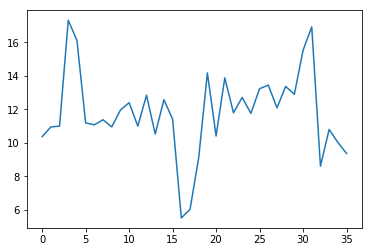

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.plot(distance)
plt.show()


In [19]:
def euclidian_distance_F(np_data_1, np_data_2): 

    if( np_data_1.shape != np_data_2.shape):
        print("==> Dimensions don't match {} {}. Clipping".format(np_data_1.shape, np_data_2.shape))
        min_dim = min(np_data_1.shape[0],  np_data_2.shape[0])

        np_data_1 = np_data_1[:min_dim,:]
        np_data_2 = np_data_2[:min_dim,:]
        
    dist = np.linalg.norm(np_data_1-np_data_2)
    return dist

In [20]:
distance_F = euclidian_distance_F(audio_embeddings, lip_embeddings)
print(distance_F)

72.2783


In [23]:
def syncnet_run(video):
    print("*" * 30)
    print(video)
    print("*" * 30)
    convert_video_to_25_fps(video)

    lip_input = get_syncnet_lip_model_input(video, shape_predictor_path)
    if(lip_input is None):
        print("Can't detect mouth:")
        return
    print("Lip Input Shape: {}".format(lip_input.shape))
    
    audio_input = get_syncnet_audio_model_input(video)
    print("Audio Input Shape: {}".format(audio_input.shape))

    audio_embeddings = syncnet_audio_model.predict(audio_input)
    print("Audio Embedding Shape: {}".format(audio_embeddings.shape))

    lip_embeddings = syncnet_lip_model.predict(lip_input)
    print("Lip Embedding Shape: {}".format(lip_embeddings.shape))

    distance_float = euclidian_distance_F(audio_embeddings, lip_embeddings)
    print("Distance: {}".format(distance_float))
    
    distance = euclidian_distance(audio_embeddings, lip_embeddings)
    
    plt.plot(distance)
    plt.show()


******************************
test/unsynced.mp4
******************************
FPS: 25
Frames: 184
Width: 320
Height: 240
Lip Input Shape: (36, 112, 112, 5)
Audio Input Shape: (36, 12, 20, 1)
Audio Embedding Shape: (36, 128)
Lip Embedding Shape: (36, 128)
Distance: 71.35250854492188


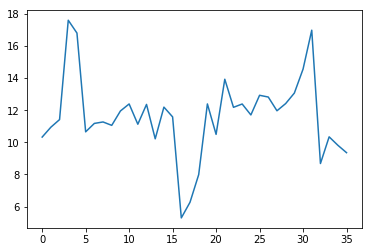

******************************
test/synced.mp4
******************************
FPS: 25
Frames: 160
Width: 320
Height: 240
Lip Input Shape: (32, 112, 112, 5)
Audio Input Shape: (31, 12, 20, 1)
Audio Embedding Shape: (31, 128)
Lip Embedding Shape: (32, 128)
==> Dimensions don't match (31, 128) (32, 128). Clipping
Distance: 66.09132385253906
==> Dimensions don't match (31, 128) (32, 128). Clipping


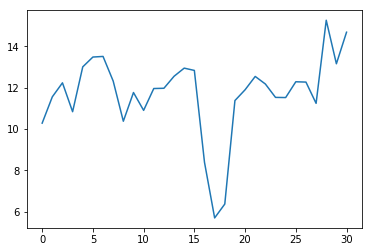

******************************
test/bad-dub-01.mp4
******************************
FPS: 25
Frames: 37
Width: 320
Height: 240
Lip Input Shape: (7, 112, 112, 5)
Audio Input Shape: (7, 12, 20, 1)
Audio Embedding Shape: (7, 128)
Lip Embedding Shape: (7, 128)
Distance: 24.290674209594727


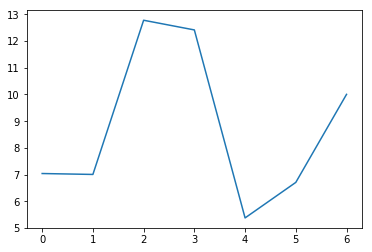

******************************
test/bad-dub-02.mp4
******************************
FPS: 25
Frames: 69
Width: 320
Height: 240
Lip Input Shape: (13, 112, 112, 5)
Audio Input Shape: (13, 12, 20, 1)
Audio Embedding Shape: (13, 128)
Lip Embedding Shape: (13, 128)
Distance: 35.15667724609375


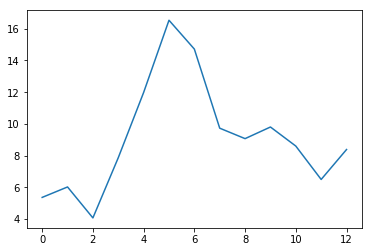

******************************
test/bad-dub-03.mp4
******************************
FPS: 25
Frames: 134
Width: 320
Height: 240
Lip Input Shape: (26, 112, 112, 5)
Audio Input Shape: (26, 12, 20, 1)
Audio Embedding Shape: (26, 128)
Lip Embedding Shape: (26, 128)
Distance: 61.18946838378906


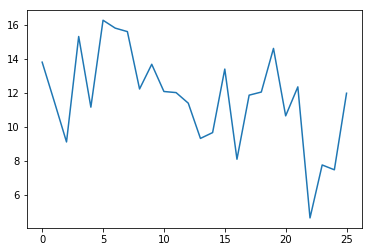

******************************
test/bad-dub-04.mp4
******************************
FPS: 25
Frames: 89
Width: 320
Height: 240
Can't detect mouth:
******************************
test/bad-dub-05.mp4
******************************
FPS: 25
Frames: 42
Width: 320
Height: 240
Lip Input Shape: (8, 112, 112, 5)
Audio Input Shape: (8, 12, 20, 1)
Audio Embedding Shape: (8, 128)
Lip Embedding Shape: (8, 128)
Distance: 30.889667510986328


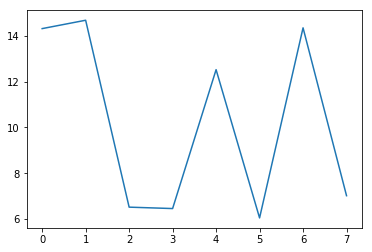

******************************
test/bad-dub-06.mp4
******************************
FPS: 25
Frames: 107
Width: 320
Height: 240
Lip Input Shape: (21, 112, 112, 5)
Audio Input Shape: (21, 12, 20, 1)
Audio Embedding Shape: (21, 128)
Lip Embedding Shape: (21, 128)
Distance: 29.280153274536133


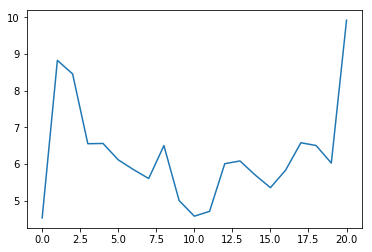

******************************
test/bad-dub-07.mp4
******************************
FPS: 25
Frames: 119
Width: 320
Height: 240
Lip Input Shape: (23, 112, 112, 5)
Audio Input Shape: (23, 12, 20, 1)
Audio Embedding Shape: (23, 128)
Lip Embedding Shape: (23, 128)
Distance: 79.18867492675781


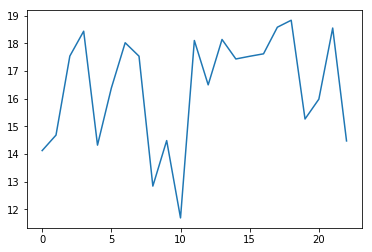

******************************
test/bad-dub-multispeaker.mp4
******************************
FPS: 25
Frames: 545
Width: 320
Height: 240
Can't detect mouth:


In [29]:
from os import listdir
from os.path import isfile, join


syncnet_run("test/unsynced.mp4")
syncnet_run("test/synced.mp4")

test_path="test/"
for f in listdir(test_path):
    tfile=join(test_path, f)
    if(isfile(tfile) and f.startswith("bad-dub") and f.endswith(".mp4")):
        syncnet_run(tfile)